In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from scipy.stats import entropy
from optht import optht
from scipy.optimize import minimize
from scipy import stats
from sklearn import preprocessing
import itertools
from matplotlib import cm
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import seaborn as sns
from math import pi
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from matplotlib.lines import Line2D
# mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

dpi = 300
width = 7.5
height = 4.5
etf_er = pd.read_pickle('etf_er.pkl')
etf_meta = pd.read_csv('etf_list.csv', index_col=0)
etf_er = etf_er.reindex(etf_meta.index, axis=1)

# The J Issue

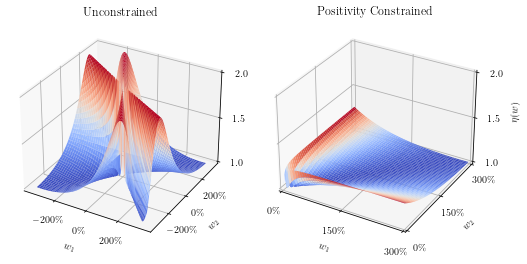

In [3]:
def effective_bets(weights, singular_values_matrix, eigen_vector_matrix, vol, k=None):
    w = weights.reshape(-1, 1)
    eigen_wts = eigen_vector_matrix.T @ np.diag(vol) @ w
    p = (np.diag(eigen_wts.flatten()) @ singular_values_matrix.T @ singular_values_matrix @ eigen_wts).flatten()
    p_norm = np.divide(p, p.sum())
    if k is not None:
        p_norm = p_norm[:k]
    eta = np.exp(-np.sum(np.multiply(p_norm, np.log(p_norm))))
    return eta

sample = etf_er.iloc[:, :2].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

combinations = [np.reshape(np.array(i), (S.shape[0], 1)) for i in itertools.product([1, -1], repeat=S.shape[0])]
J = np.concatenate(combinations, axis=1)
W = np.linalg.inv(D) @ V @ np.linalg.inv(S) @ J
W = np.divide(W, W.sum(axis=0))
# plt.style.use('grayscale')
# plt.gray()
fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(width, height))

# First panel
bounds = (-3.5, 3.5)
step_size = .01
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        w = np.array([w1, w2])
        Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)
surf = axs[0].plot_surface(X, Y, Z, cmap=cm.coolwarm)
axs[0].set_zticks([1, 1.5, 2])
axs[0].set_xlabel('$w_{1}$')
axs[0].set_ylabel('$w_{2}$')
# axs[0].set_zlabel('$\eta$', rotation=0)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0].set_title('Unconstrained')

# Second panel
bounds = (0.01, 3)
step_size = .01
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        w = np.array([w1, w2])
        Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)

surf = axs[1].plot_surface(X, Y, Z, cmap=cm.coolwarm)
axs[1].set_zticks([1, 1.5, 2])
axs[1].set_xticks([0, 1.5, 3])
axs[1].set_yticks([0, 1.5, 3])
axs[1].set_xlim(0, 3)
axs[1].set_ylim(0, 3)
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].set_xlabel('$w_{1}$')
axs[1].set_ylabel('$w_{2}$')
axs[1].set_zlabel('$\eta (w)$', rotation=0)
axs[1].set_title('Positivity Constrained')

plt.tight_layout(pad=3)

# plt.savefig(rf'{wd}\img\j_issue.pdf', dpi=dpi, transparent=True)

plt.show()

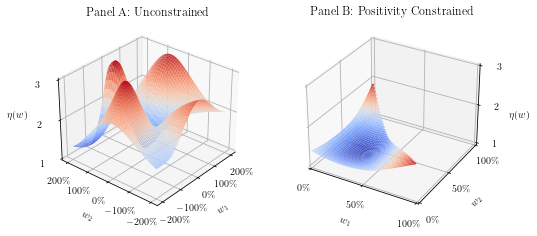

In [2]:
def effective_bets(weights, singular_values_matrix, eigen_vector_matrix, vol, k=None):
    w = weights.reshape(-1, 1)
    eigen_wts = eigen_vector_matrix.T @ np.diag(vol) @ w
    p = (np.diag(eigen_wts.flatten()) @ singular_values_matrix.T @ singular_values_matrix @ eigen_wts).flatten()
    p_norm = np.divide(p, p.sum())
    if k is not None:
        p_norm = p_norm[:k]
    eta = np.exp(-np.sum(np.multiply(p_norm, np.log(p_norm))))
    return eta

sample = etf_er[['IYW', 'IYK', 'IYC']].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

combinations = [np.reshape(np.array(i), (S.shape[0], 1)) for i in itertools.product([1, -1], repeat=S.shape[0])]
J = np.concatenate(combinations, axis=1)
W = np.linalg.inv(D) @ V @ np.linalg.inv(S) @ J
W = np.divide(W, W.sum(axis=0))

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(width, height))

# First panel
bounds = (-2, 2)
step_size = 0.01
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        w = np.array([w1, w2, 1 - w1 - w2])
        Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)

surf = axs[0].plot_surface(X, Y, Z, cmap=cm.coolwarm)
axs[0].view_init(azim=220, elev=30)
axs[0].set_zlim(1, 3)
axs[0].set_zticks([1, 2, 3])
axs[0].set_xlabel('$w_{1}$')
axs[0].set_ylabel('$w_{2}$')
# axs[0].set_zlabel('$\eta(w)$', rotation=90)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0].set_title('Panel A: Unconstrained')

# Second panel
bounds = (0, 1)
step_size = .001
w_i = np.arange(bounds[0], bounds[1], step_size)
X = w_i
Y = w_i
X, Y = np.meshgrid(X, Y)

Z = pd.DataFrame(index=range(X.shape[0]), columns=range(Y.shape[0]), dtype=float)
for r in Z.index:
    for c in Z.columns:
        w1 = X[r, c]
        w2 = Y[r, c]
        if w1 + w2 < 1:
            w = np.array([w1, w2, 1 - w1 - w2])
            Z.loc[r, c] = effective_bets(w, S, V, np.diag(D), k=None)
        else:
            Z.loc[r, c] = np.nan

Z_diag = Z.fillna(method='ffill', axis=1)
X_diag = pd.DataFrame(X)
X_diag = X_diag.where(~Z.isnull())
X_diag.fillna(method='ffill', axis=1)

surf = axs[1].plot_surface(X_diag, Y, Z_diag, cmap=cm.coolwarm)
axs[1].view_init(azim=-60, elev=30)
axs[1].set_zticks([1, 2, 3])
axs[1].set_xticks([0, 0.5, 1])
axs[1].set_yticks([0, 0.5, 1])
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].set_xlabel('$w_{1}$')
axs[1].set_ylabel('$w_{2}$')

axs[1].set_title('Panel B: Positivity Constrained')
fig.text(.945, .5, s='$\eta (w)$')
fig.text(.015, .5, s='$\eta (w)$')
plt.tight_layout(pad=5)
plt.savefig('j_issue.pdf', dpi=dpi, transparent=True)

plt.show()

In [112]:
etf_meta.loc[['IYW', 'IYK', 'IYC']]

,name,asset,region,aesthetic
ticker,,,,
IYW,iShares Dow Jones U.S. Technology,Equities,United States,U.S. Technology
IYK,iShares Dow Jones U.S. Consumer Goods,Equities,United States,U.S. Consumer Goods
IYC,iShares Dow Jones U.S. Consumer Services,Equities,United States,U.S. Consumer Services


# Factor exposure of risk parity and factor risk contribution

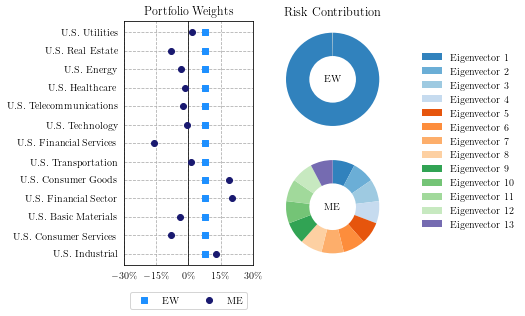

In [4]:
# Correlation matrix
sample = etf_er.iloc[:, :13].copy()
sample.columns = [etf_meta.loc[x, 'aesthetic'] for x in sample.columns]
Rho = sample.dropna().corr().values
S = np.diag(sample.std())

# We diagonalize Rho into its eigen-vector and eigen-value matrices
Lambda, V = np.linalg.eig(Rho)
order = Lambda.argsort()[::-1]
Lambda = np.diag(Lambda[order])
V = V[:, order]

# Spectral risk parity (SRP)
n = Lambda.shape[0]  # Number of elements
w_esrc = np.linalg.inv(S) @ V @ np.power(np.linalg.inv(Lambda), 1/2) @ np.ones(n).reshape(-1, 1)
w_esrc = w_esrc / w_esrc.sum()
w_esrc = w_esrc / np.abs(w_esrc).sum()

# Benchmark methodologies
w_equally = np.array([1 / n] * n).reshape(-1, 1)
Sigma = sample.cov().values

# Calculate the diversification distribution vector (p_n) for each
p_equally = np.multiply(V.T @ S @ w_equally, Lambda @ V.T @ S @ w_equally) / (w_equally.T @ Sigma @ w_equally)
p_esrc = (np.diag((V.T @ S @ w_esrc).flatten()) @ Lambda @ V.T @ S @ w_esrc) / (w_esrc.T @ S @ Rho @ S @ w_esrc)

# Finally we calculate the effective number of bets for each portfolio
enb_equally = np.exp(-np.sum(np.multiply(p_equally, np.log(p_equally))))
enb_srp = np.exp(-np.sum(np.multiply(p_esrc, np.log(p_esrc))))

port_name = ['EW Risk Contribution', 'SRP Risk Contribution']
enb_all = dict(zip(port_name, [enb_equally, enb_srp]))

# Let's visualize the results
theta = pd.DataFrame(np.concatenate([p_equally, p_esrc], axis=1), columns=port_name, index=sample.columns)
color_map = list(cm.get_cmap('tab20c')(range(13)))

fig = plt.figure(tight_layout=True, figsize=(width, height * 1))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3])

for i in range(2):
    label = port_name[i]
    ax_ = fig.add_subplot(gs[i, 1])
    ax_.pie(
        theta[label],
        normalize=True,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.5),
        colors=color_map
    )
    if i == 0:
        ax_.set_title('Risk Contribution', fontsize=12.5)
        ax_.text(-.18, -.05, 'EW')
    else:
        ax_.text(-.18, -.05, 'ME')

fig.legend([f'Eigenvector {x + 1}' for x in range(n)], bbox_to_anchor=(.975, .85), ncol=1, frameon=False)

ax = fig.add_subplot(gs[:, 0])
ax.scatter(y=range(len(w_equally)), x=w_equally.squeeze(), zorder=100, marker='s', color='dodgerblue')
ax.scatter(y=range(len(w_equally)), x=w_esrc.squeeze(), zorder=100, marker='o', color='midnightblue')
ax.grid(ls='--', zorder=-99)
ax.set_xlim(-.3, .3)
ax.set_xticks([-.3, -.15, 0, .15, .3])
ax.set_yticks(range(len(w_equally)))
ax.set_yticklabels(sample.columns)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.legend(['EW', 'ME'], ncol=2, loc="lower center", bbox_to_anchor=(0.5, -0.2))
ax.tick_params(axis='both', bottom=False, left=False)
ax.set_title('Portfolio Weights')
ax.axvline(0, lw=.75, c='k', zorder=50)

plt.tight_layout()
plt.savefig('spectral_rc.pdf', dpi=dpi, transparent=True)
plt.show()

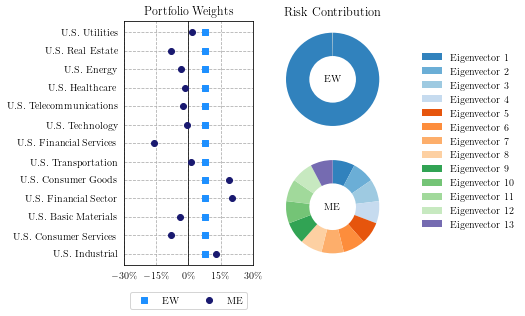

In [54]:
# Correlation matrix
sample = etf_er.iloc[:, :13].copy()
sample.columns = [etf_meta.loc[x, 'aesthetic'] for x in sample.columns]
Rho = sample.dropna().corr().values
S = np.diag(sample.std())

# We diagonalize Rho into its eigen-vector and eigen-value matrices
Lambda, V = np.linalg.eig(Rho)
order = Lambda.argsort()[::-1]
Lambda = np.diag(Lambda[order])
V = V[:, order]

# Spectral risk parity (SRP)
n = Lambda.shape[0]  # Number of elements
w_esrc = np.linalg.inv(S) @ V @ np.power(np.linalg.inv(Lambda), 1/2) @ np.ones(n).reshape(-1, 1)
w_esrc = w_esrc / w_esrc.sum()
w_esrc = w_esrc / np.abs(w_esrc).sum()

# Benchmark methodologies
w_equally = np.array([1 / n] * n).reshape(-1, 1)
Sigma = sample.cov().values

# Calculate the diversification distribution vector (p_n) for each
p_equally = (np.diag((V.T @ S @ w_equally).flatten()) @ Lambda @ V.T @ S @ w_equally) / (w_equally.T @ Sigma @ w_equally)
p_esrc = (np.diag((V.T @ S @ w_esrc).flatten()) @ Lambda @ V.T @ S @ w_esrc) / (w_esrc.T @ S @ Rho @ S @ w_esrc)

# Finally we calculate the effective number of bets for each portfolio
enb_equally = np.exp(-np.sum(np.multiply(p_equally, np.log(p_equally))))
enb_srp = np.exp(-np.sum(np.multiply(p_esrc, np.log(p_esrc))))

port_name = ['EW Risk Contribution', 'SRP Risk Contribution']
enb_all = dict(zip(port_name, [enb_equally, enb_srp]))

# Let's visualize the results
theta = pd.DataFrame(np.concatenate([p_equally, p_esrc], axis=1), columns=port_name, index=sample.columns)
color_map = list(cm.get_cmap('tab20c')(range(13)))

fig = plt.figure(tight_layout=True, figsize=(width, height * 1))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3])

for i in range(2):
    label = port_name[i]
    ax_ = fig.add_subplot(gs[i, 1])
    ax_.pie(
        theta[label],
        normalize=True,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.5),
        colors=color_map
    )
    if i == 0:
        ax_.set_title('Risk Contribution', fontsize=12.5)
        ax_.text(-.18, -.05, 'EW')
    else:
        ax_.text(-.18, -.05, 'ME')

fig.legend([f'Eigenvector {x + 1}' for x in range(n)], bbox_to_anchor=(.975, .85), ncol=1, frameon=False)

ax = fig.add_subplot(gs[:, 0])
ax.scatter(y=range(len(w_equally)), x=w_equally.squeeze(), zorder=100, marker='s', color='dodgerblue')
ax.scatter(y=range(len(w_equally)), x=w_esrc.squeeze(), zorder=100, marker='o', color='midnightblue')
ax.grid(ls='--', zorder=-99)
ax.set_xlim(-.3, .3)
ax.set_xticks([-.3, -.15, 0, .15, .3])
ax.set_yticks(range(len(w_equally)))
ax.set_yticklabels(sample.columns)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.legend(['EW', 'ME'], ncol=2, loc="lower center", bbox_to_anchor=(0.5, -0.2))
ax.tick_params(axis='both', bottom=False, left=False)
ax.set_title('Portfolio Weights')
ax.axvline(0, lw=.75, c='k', zorder=50)

plt.tight_layout()
plt.savefig('spectral_rc.pdf', dpi=dpi, transparent=True)
plt.show()

# Allocation interchangeability
https://stats.stackexchange.com/questions/115032/how-to-find-which-variables-are-most-correlated-with-the-first-principal-compone

In [113]:
sample = etf_er.copy().dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)
t, n = sample.shape

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T
pc1_sign = np.sign(V[:, 0].sum())
V = np.multiply(V, pc1_sign)

rho_pc = np.divide(V @ S, np.sqrt(t - 1))
rho_pc1 = rho_pc[:, 0]  # Correlation with the first eigenvector

In [114]:
rho_pc = pd.DataFrame(
    np.divide(V @ S, np.sqrt(t - 1)),
    index=[etf_meta.loc[x, 'aesthetic'] for x in sample.columns],
    columns=[f'L{x}' for x in range(V.shape[1])]
)
rho_pc

,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L21,L22,L23,L24,L25,L26,L27,L28,L29,L30
U.S. Industrial,0.948473,0.082304,0.052630,-0.093360,0.020188,-0.067757,0.004924,-0.020615,-0.018541,-0.049362,...,0.001697,0.032166,0.021305,-0.001996,-0.022123,-0.006350,0.195416,0.009685,-0.008614,-0.001058
U.S. Consumer Services,0.905120,0.100731,0.131940,-0.104946,0.051368,-0.089726,-0.001121,0.105893,-0.065402,-0.142220,...,0.011364,-0.073775,-0.109361,0.055531,0.167837,0.158654,-0.009154,-0.004830,-0.003528,-0.000812
U.S. Basic Materials,0.888392,0.117210,-0.164602,-0.059335,-0.049442,0.050633,0.036805,-0.124381,-0.023996,0.054076,...,-0.084231,0.075494,0.257967,0.015586,0.057401,0.063768,-0.047073,-0.004232,0.002139,-0.000874
U.S. Financial Sector,0.890342,0.046817,0.153247,-0.161887,-0.049092,-0.149929,-0.258609,-0.150389,0.069600,-0.016921,...,0.096571,0.005061,0.020708,0.008911,-0.001558,0.003971,-0.006811,-0.001490,0.002228,0.058243
U.S. Consumer Goods,0.876470,0.148865,0.074956,-0.028551,0.171978,-0.047350,0.091982,0.176492,-0.002398,0.034686,...,0.084411,-0.273957,0.117822,-0.025695,-0.032885,-0.052183,-0.012878,-0.004792,0.003074,-0.001223
U.S. Transportation,0.871031,0.052024,0.092805,-0.118776,-0.012017,-0.118729,-0.040115,-0.052028,-0.034727,-0.083051,...,-0.017312,0.051806,-0.122090,-0.023276,-0.066381,-0.054118,-0.074603,0.003156,0.001035,0.000659
U.S. Financial Services,0.865795,0.002823,0.154630,-0.144403,-0.091760,-0.157828,-0.254650,-0.185373,0.051389,-0.055332,...,0.175929,0.019901,0.019770,0.011191,-0.003138,0.006815,-0.012659,-0.001716,-0.000088,-0.047297
U.S. Technology,0.853880,0.096052,0.066849,-0.078055,0.015160,0.014354,0.068786,0.179987,-0.110465,-0.236938,...,0.093504,0.071951,0.010820,-0.020151,-0.079926,-0.048588,-0.028753,0.001750,0.002439,0.001641
U.S. Telecommunications,0.853453,0.129849,0.093941,-0.097160,0.055165,-0.026551,0.022434,0.101748,0.011344,0.023154,...,-0.039995,0.006263,0.004786,-0.002710,-0.003037,-0.023626,0.000188,-0.001322,0.000310,-0.000601
U.S. Healthcare,0.816695,0.110995,0.093834,-0.051116,0.168528,-0.052977,0.166722,0.252869,0.006086,-0.092011,...,-0.131613,0.081218,-0.018959,0.001078,-0.012736,-0.008677,-0.008521,0.000574,0.001541,-0.000566


In [115]:
test_dt = pd.date_range(start='2018-12-31', end='2021-12-31', freq='M')
res = pd.DataFrame(index=test_dt, columns=sample.columns)
wdw = pd.DateOffset(months=120)

for dt in test_dt:
    sample = etf_er.loc[dt - wdw:dt].copy().dropna()
    # sample = etf_er.loc[:dt].copy().dropna()
    scaler = preprocessing.StandardScaler().fit(sample)
    sample_z = scaler.transform(sample)
    t, n = sample.shape

    D = np.diag(np.sqrt(scaler.var_))
    U, s, Vt = svd(
        sample_z,
        full_matrices=False,
        compute_uv=True,
        lapack_driver='gesdd'
    )
    S = np.diag(s)
    V = Vt.T
    pc1_sign = np.sign(V[:, 0].sum())
    V = np.multiply(V, pc1_sign)

    w_star = np.linalg.inv(D) @ V @ np.linalg.inv(S) @ np.ones((n, 1))
    w_star = np.divide(w_star, w_star.sum())
    res.loc[dt] = w_star.squeeze()

res = res.astype(float)
res = res.clip(-1, 1)

# Dendrogram
https://stackoverflow.com/questions/22726969/how-to-generate-d3-js-circular-dendrogram-code-from-python
https://observablehq.com/@d3/radial-tree?collection=@d3/charts


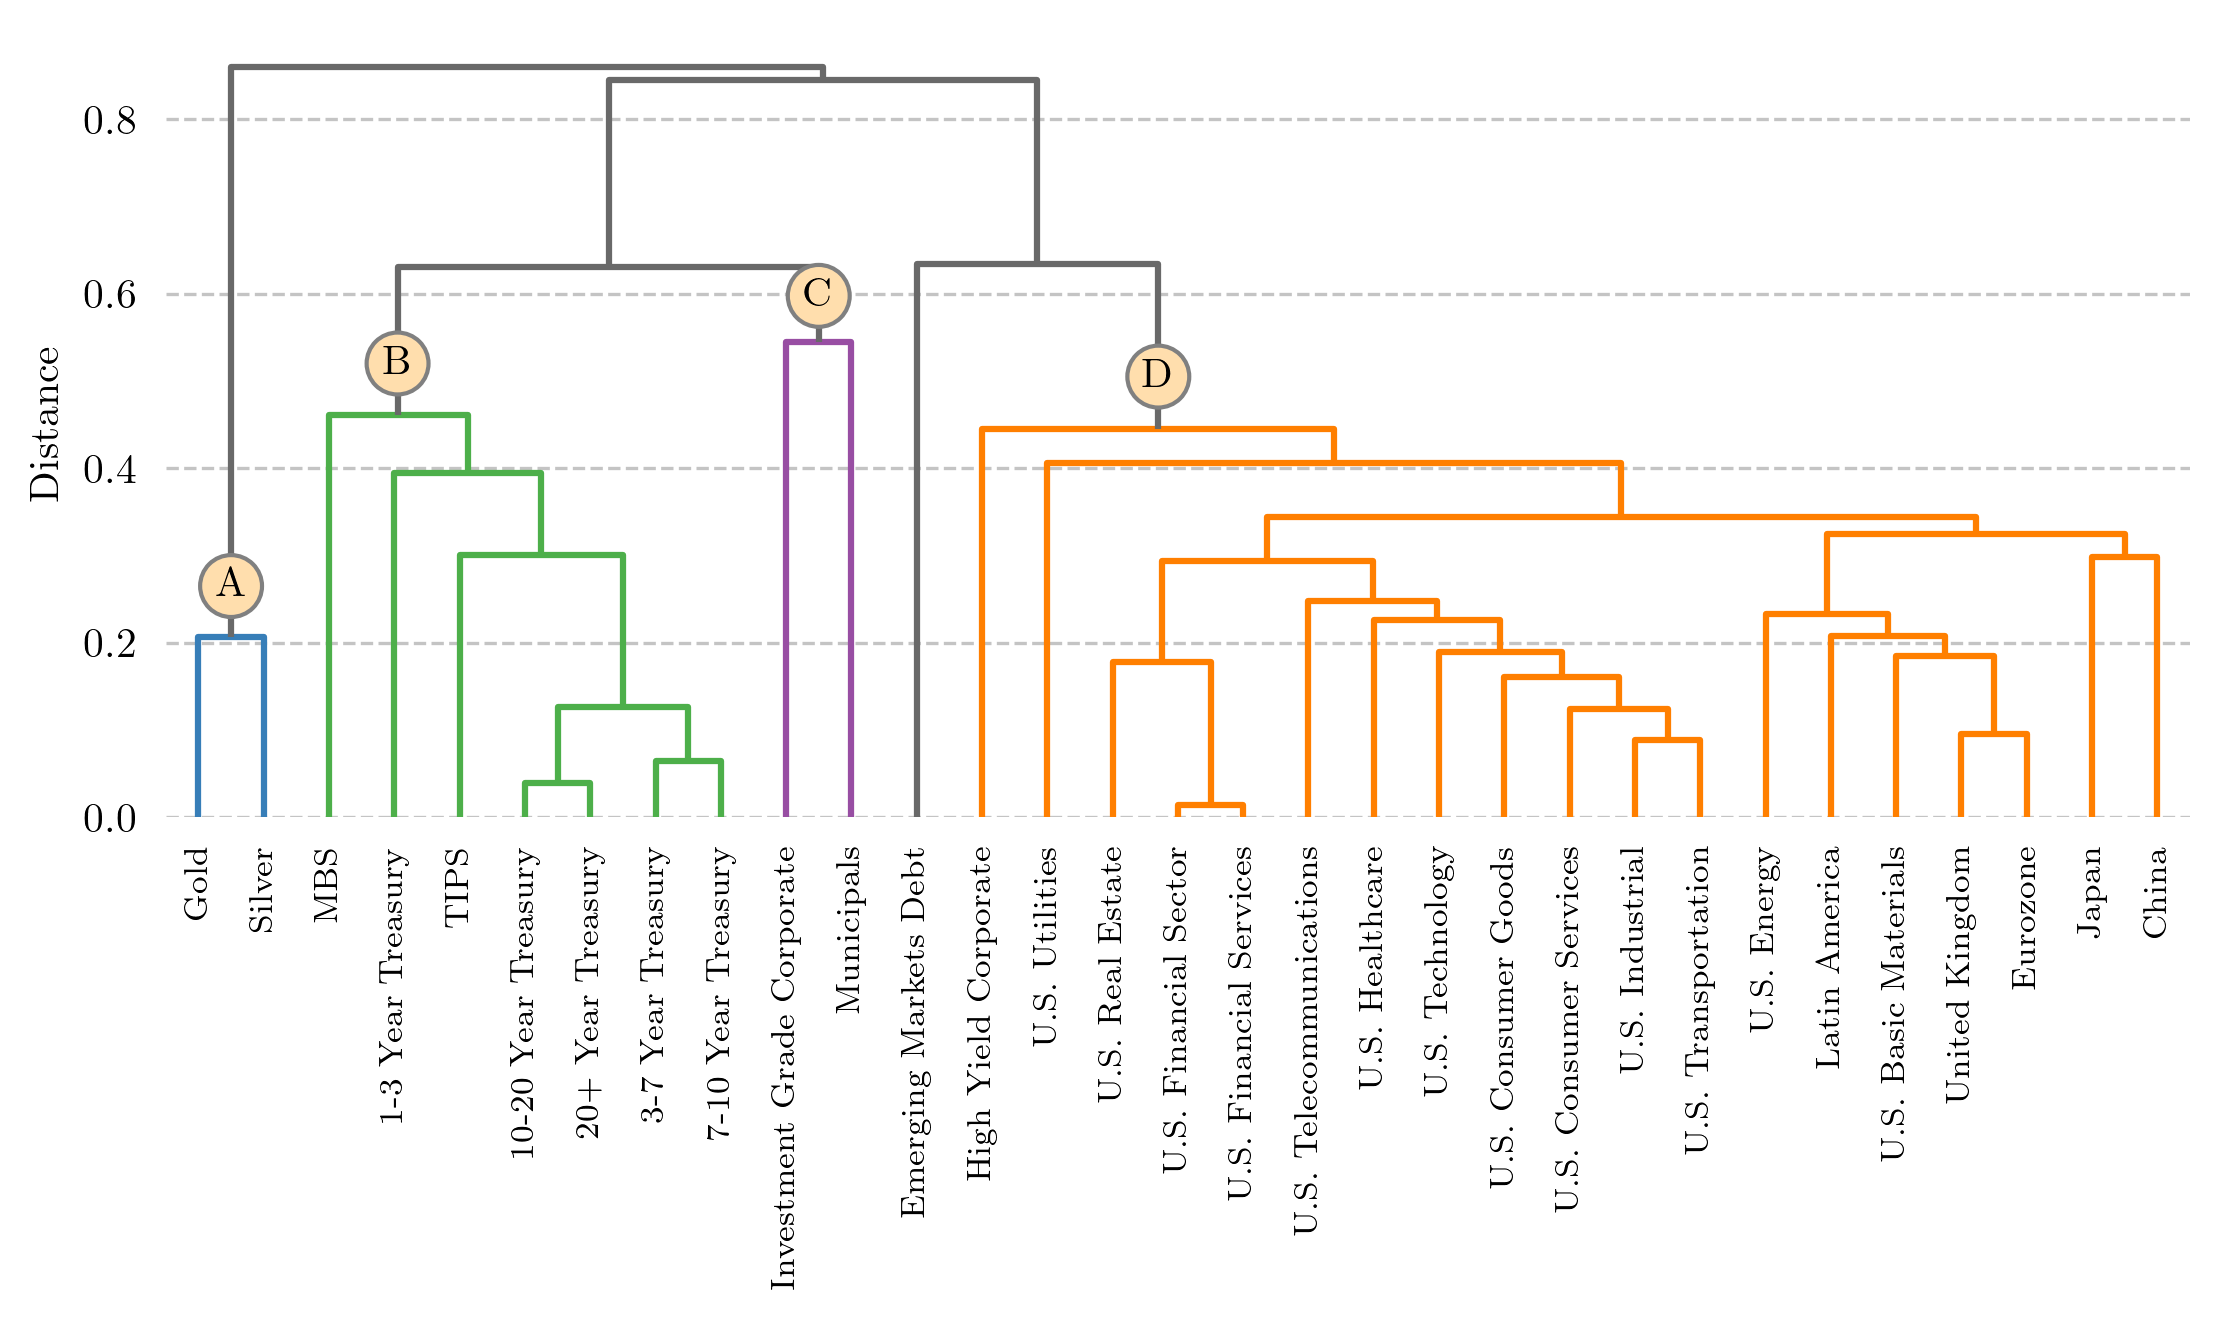

In [50]:
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy


sample = etf_er.loc['2008':'2021'].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)
t, n = sample.shape

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

L = V @ S
distance = pdist(L, metric='cosine')

fig, ax = plt.subplots(figsize=(width, height), dpi=dpi)
R = dendrogram(
    Z=linkage(distance, method='weighted', metric='cosine'),
    distance_sort=True,
    get_leaves=True,
    ax=ax,
    color_threshold=.6,
    above_threshold_color='dimgray',
    # link_color_func=lambda x: cmap[x]
)

ax.grid(ls='--', axis='y', alpha=.75)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(left=False)

sorted_idx = R['leaves']
ax.set_xticklabels([etf_meta.loc[x, 'aesthetic'] for x in sample.columns[sorted_idx]], rotation=90)
ax.set_ylabel('Distance')
plt.tight_layout()

colormap = cm.Accent(range(1, 6))
colormap = cm.Dark2(range(3, 7))
colormap = cm.Set1(range(1, 5))
# colormap = cm.gray(range(1, 5))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in colormap])

ax.text(x=10, y=.265, s='A', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'navajowhite', 'alpha': 1, 'ec': 'gray'})
ax.text(x=35.5, y=.52, s='B', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'navajowhite', 'alpha': 1, 'ec': 'gray'})
ax.text(x=100, y=.5975, s='C', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'navajowhite', 'alpha': 1, 'ec': 'gray'})
ax.text(x=152, y=.505, s='D', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'navajowhite', 'alpha': 1, 'ec': 'gray'})

# ax.text(x=10, y=.265, s='A', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'whitesmoke', 'alpha': 1, 'ec': 'gray'})
# ax.text(x=35.5, y=.52, s='B', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'whitesmoke', 'alpha': 1, 'ec': 'gray'})
# ax.text(x=100, y=.5975, s='C', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'whitesmoke', 'alpha': 1, 'ec': 'gray'})
# ax.text(x=152, y=.505, s='D', ha='center', va='center', bbox={'boxstyle': 'circle, pad=.3', 'fc': 'whitesmoke', 'alpha': 1, 'ec': 'gray'})


plt.savefig('dendrogram.pdf', dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()

# Radar

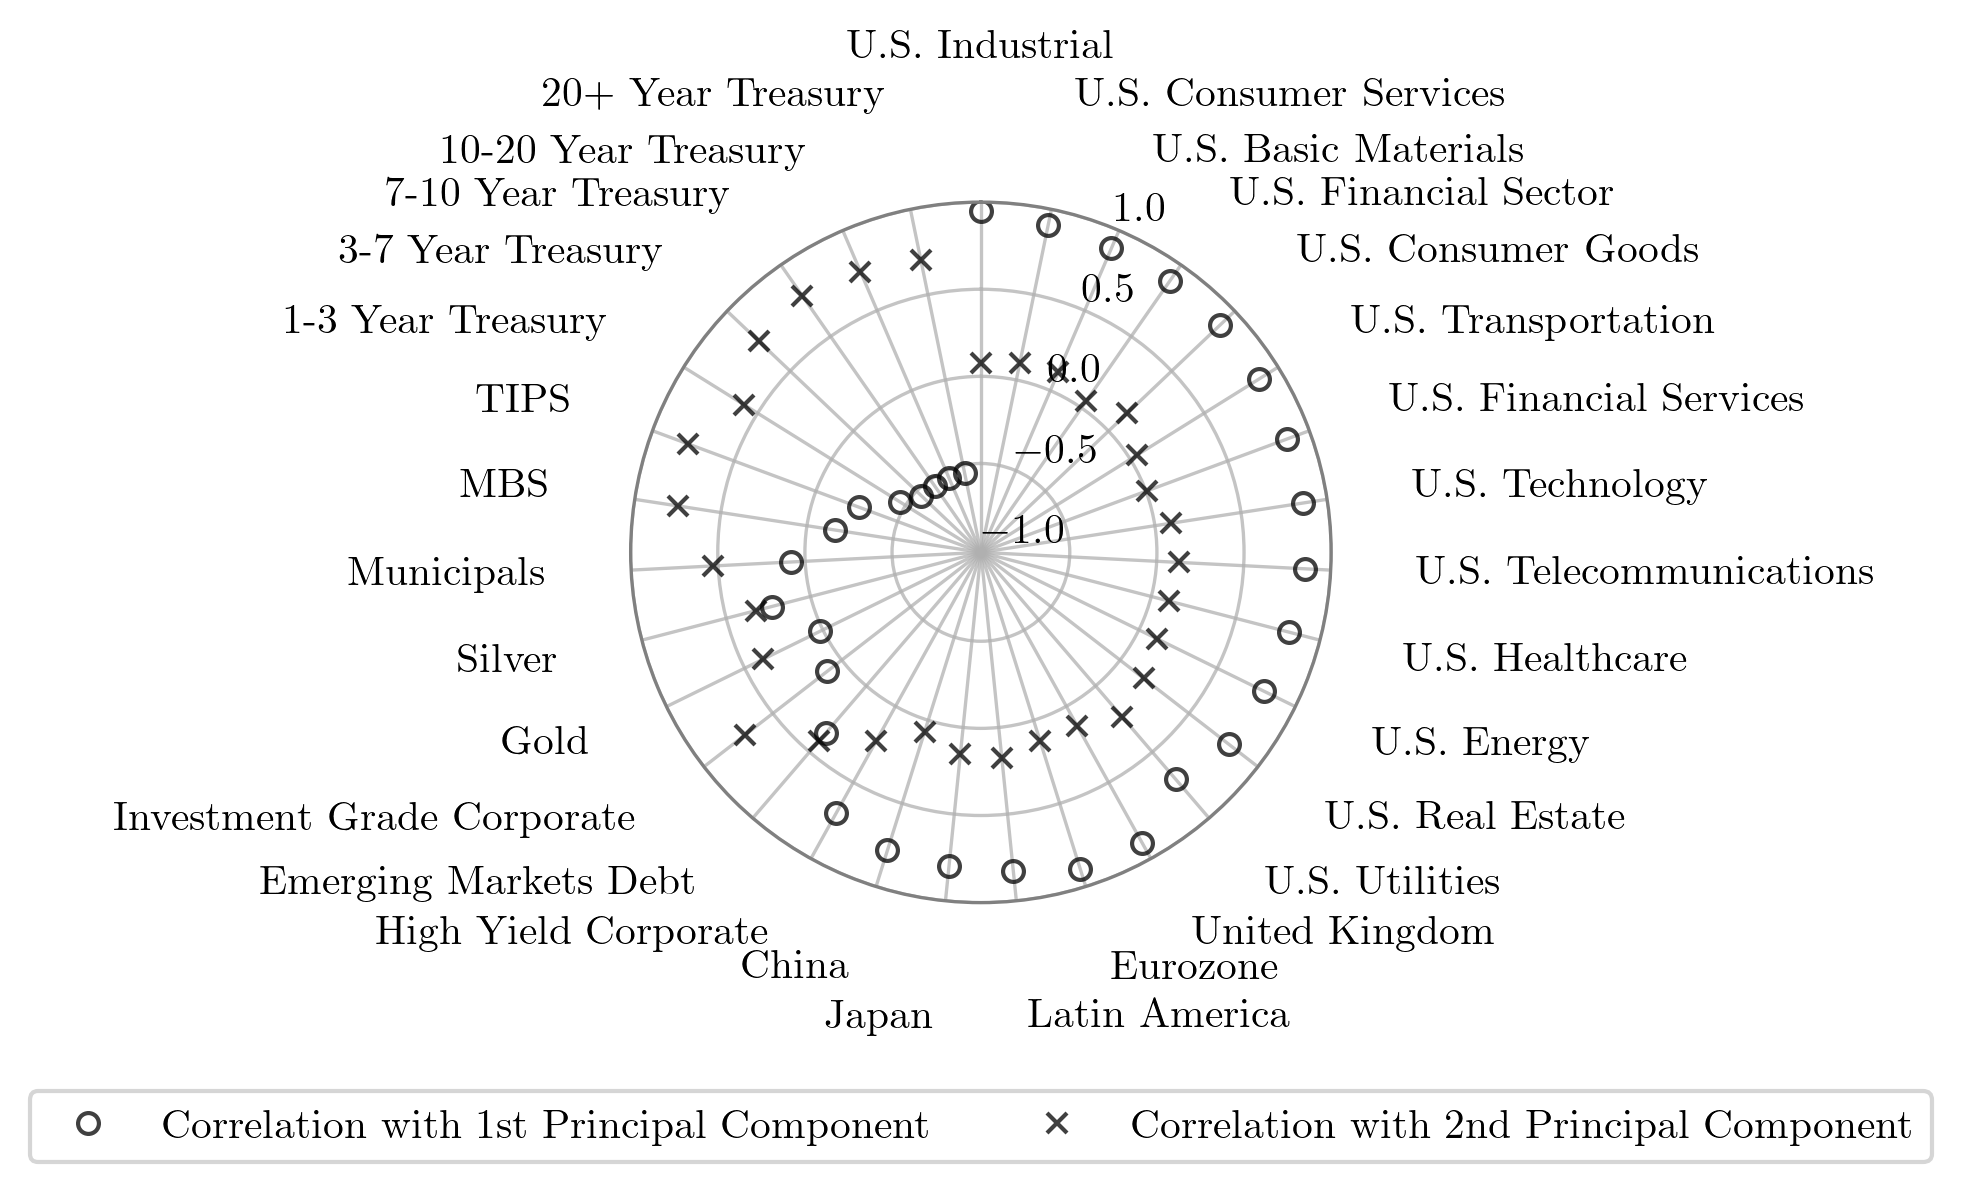

In [49]:
sample = etf_er.loc['2008':'2021'].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)
t, n = sample.shape

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

rho_pc = pd.DataFrame(
    np.divide(V @ S, np.sqrt(t - 1)),
    index=[etf_meta.loc[x, 'aesthetic'] for x in sample.columns],
    columns=[f'L{str(x + 1)}' for x in range(V.shape[1])]
)

sample_rho = rho_pc[['L1', 'L2', 'L3']]
signs = np.sign(rho_pc.sum())
sample_rho = sample_rho.mul(signs)

fig, ax = plt.subplots(figsize=(width, height), dpi=dpi, subplot_kw={'polar': True})

# number of variable
categories=list(rho_pc.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles), categories)
ax.grid(ls='-', which='both', alpha=.75)

for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

ax.spines['start'].set_color('none')
ax.spines['polar'].set_color('gray')
ax.set_ylim(-1.01, 1)
# plt.rcParams['axes.titlepad'] = 40

values = list(sample_rho['L1'])
ax.plot(
    angles,
    values,
    mfc='none',
    mec='black',
    marker='o',
    ms=5,
    alpha=.75,
    ls=None,
    lw=0
)

values = list(sample_rho['L2'])
ax.plot(
    angles,
    values,
    mfc='none',
    mec='black',
    marker='x',
    ms=5,
    alpha=.75,
    ls=None,
    lw=0
)

ax.set_yticks([-1, -.5, 0, .5, 1])

extra_space = ['Japan', 'Latin America', '20+ Year Treasury', 'U.S. Consumer Services']
for tick in ax.get_xaxis().get_major_ticks():
    if tick.label.get_text() in extra_space:
        tick.set_pad(17.5)
    elif tick.label.get_text() in ['U.S. Industrial']:
        tick.set_pad(26.5)
    else:
        tick.set_pad(10)

# ax.fill(angles, np.ones(len(angles)) * 100, color='floralwhite')

lgd = ax.legend(
    ['Correlation with 1st Principal Component', 'Correlation with 2nd Principal Component'],
    loc='lower center',
    bbox_to_anchor=(.5, -.4),
    ncol=2,
    # fontsize=8,
    # frameon=False
)

plt.tight_layout()
plt.savefig('correlation_pc.pdf', dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

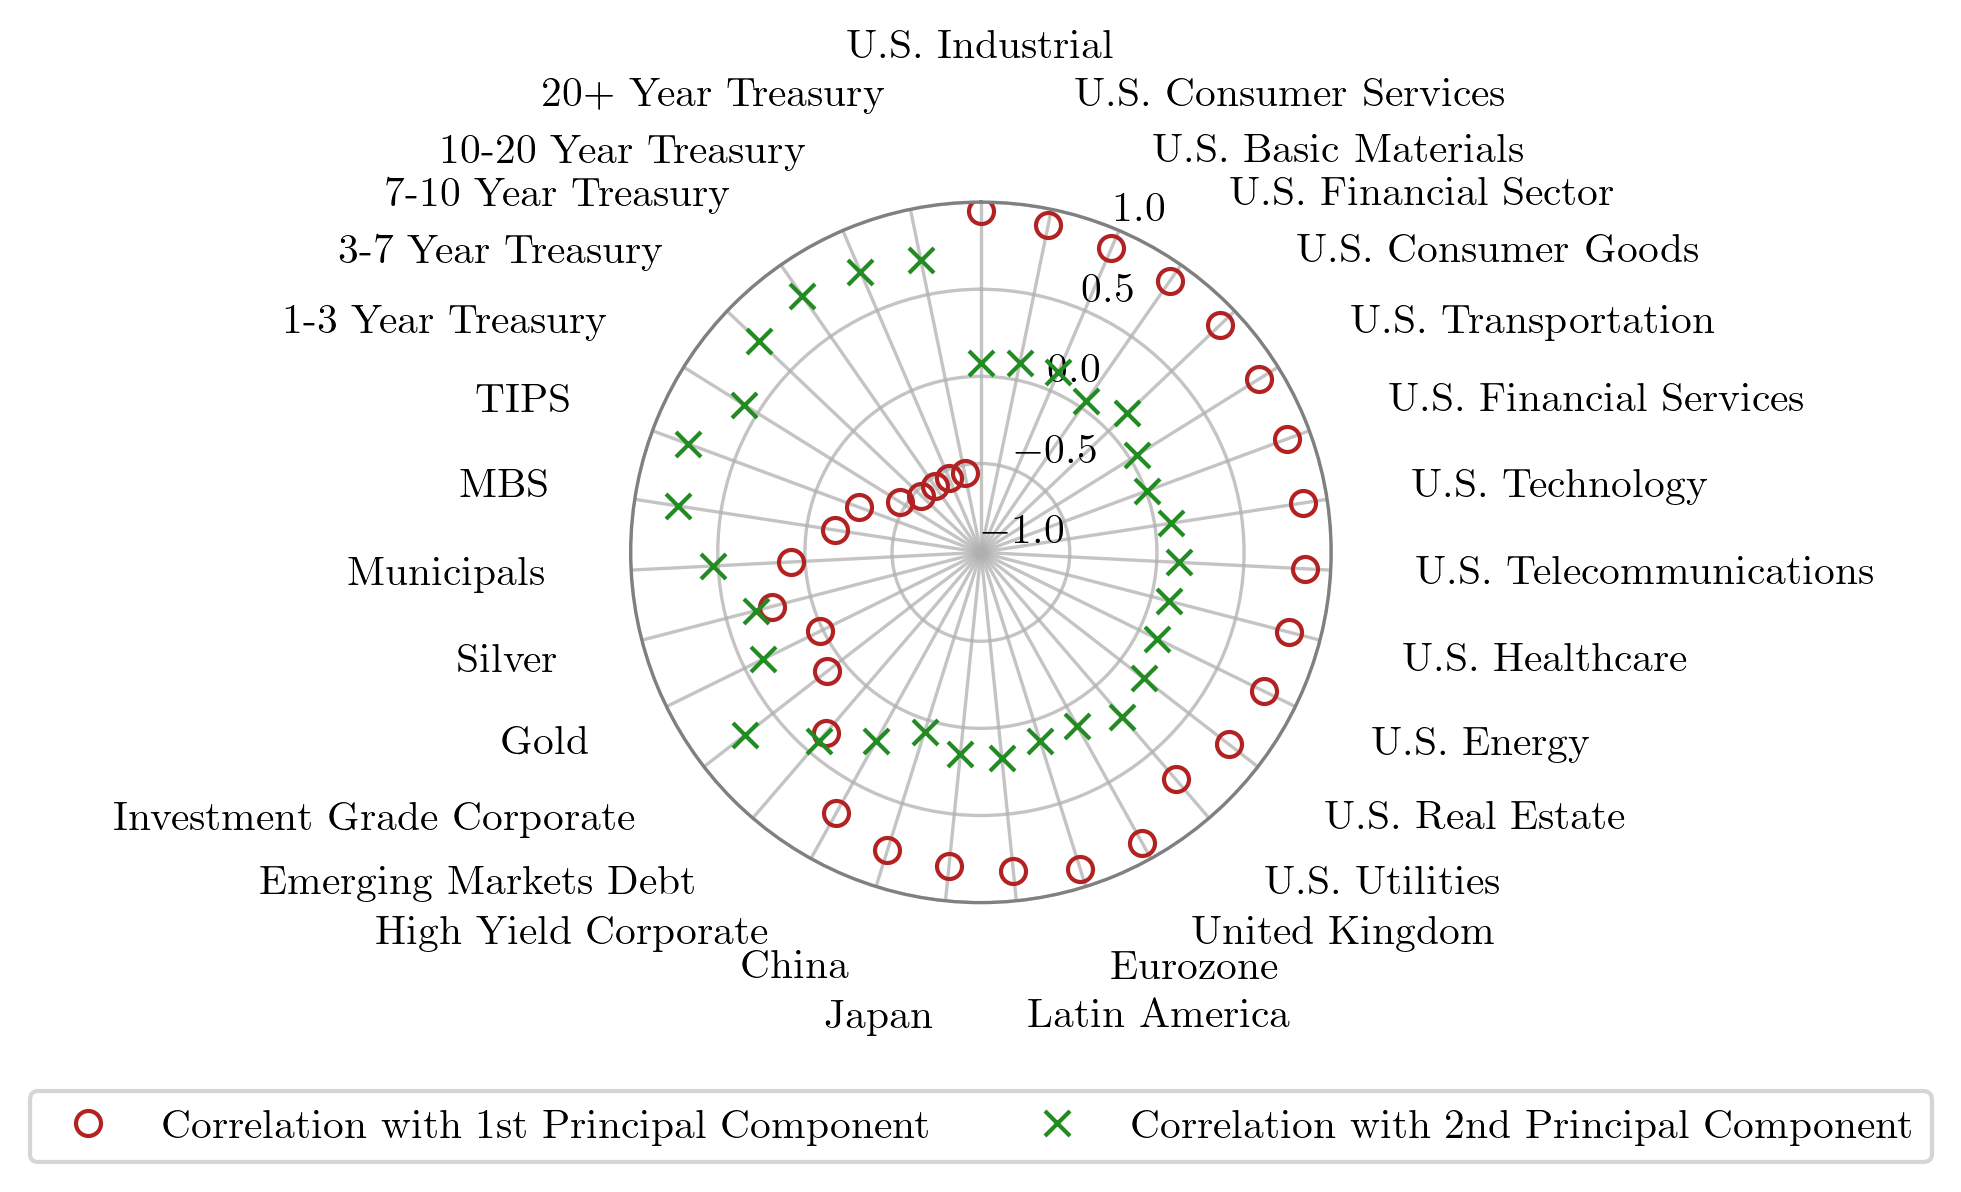

In [52]:
sample = etf_er.loc['2008':'2021'].dropna()
scaler = preprocessing.StandardScaler().fit(sample)
sample_z = scaler.transform(sample)
t, n = sample.shape

D = np.diag(np.sqrt(scaler.var_))
U, s, Vt = svd(
    sample_z,
    full_matrices=False,
    compute_uv=True,
    lapack_driver='gesdd'
)
S = np.diag(s)
V = Vt.T

rho_pc = pd.DataFrame(
    np.divide(V @ S, np.sqrt(t - 1)),
    index=[etf_meta.loc[x, 'aesthetic'] for x in sample.columns],
    columns=[f'L{str(x + 1)}' for x in range(V.shape[1])]
)

sample_rho = rho_pc[['L1', 'L2', 'L3']]
signs = np.sign(rho_pc.sum())
sample_rho = sample_rho.mul(signs)

fig, ax = plt.subplots(figsize=(width, height), dpi=dpi, subplot_kw={'polar': True})

# number of variable
categories=list(rho_pc.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles), categories)
ax.grid(ls='-', which='both', alpha=.75)

for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

ax.spines['start'].set_color('none')
ax.spines['polar'].set_color('gray')
ax.set_ylim(-1.01, 1)
# plt.rcParams['axes.titlepad'] = 40

values = list(sample_rho['L1'])
ax.plot(
    angles,
    values,
    mfc='none',
    mec='firebrick',
    marker='o',
    ms=6,
    alpha=1,
    ls=None,
    lw=0
)

values = list(sample_rho['L2'])
ax.plot(
    angles,
    values,
    mfc='forestgreen',
    mec='forestgreen',
    marker='x',
    ms=6,
    alpha=1,
    ls=None,
    lw=0
)

ax.set_yticks([-1, -.5, 0, .5, 1])

extra_space = ['Japan', 'Latin America', '20+ Year Treasury', 'U.S. Consumer Services']
for tick in ax.get_xaxis().get_major_ticks():
    if tick.label.get_text() in extra_space:
        tick.set_pad(17.5)
    elif tick.label.get_text() in ['U.S. Industrial']:
        tick.set_pad(26.5)
    else:
        tick.set_pad(10)

# ax.fill(angles, np.ones(len(angles)) * 100, color='floralwhite')

lgd = ax.legend(
    ['Correlation with 1st Principal Component', 'Correlation with 2nd Principal Component'],
    loc='lower center',
    bbox_to_anchor=(.5, -.4),
    ncol=2,
    # fontsize=8,
    # frameon=False
)

plt.tight_layout()
plt.savefig('correlation_pc_color.pdf', dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

In [17]:
rho_pc = pd.DataFrame(
    np.divide(V @ S, np.sqrt(t - 1)),
    index=[etf_meta.loc[x, 'aesthetic'] for x in sample.columns],
    columns=[f'L{str(x + 1)}' for x in range(V.shape[1])]
)
rho_pc

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L22,L23,L24,L25,L26,L27,L28,L29,L30,L31
U.S. Industrial,0.949003,0.079558,0.049896,-0.092718,0.020078,-0.067647,0.000099,0.015127,-0.022217,-0.097736,...,-0.005566,0.035956,0.018187,-0.002201,-0.013356,-0.019259,0.194288,0.011683,-0.008629,-0.001428
U.S. Consumer Services,0.908819,0.098445,0.126904,-0.104558,0.058027,-0.085472,0.013872,-0.105560,-0.046441,-0.168351,...,-0.001659,-0.092294,-0.087655,0.039161,0.002882,0.233862,-0.008285,-0.006008,-0.005295,-0.000825
U.S. Basic Materials,0.889771,0.118252,-0.161047,-0.057740,-0.055641,0.044834,-0.043297,0.113970,-0.047857,-0.010096,...,0.079527,0.095896,0.252354,0.009739,-0.011836,0.076091,-0.047630,-0.004798,0.002179,-0.000708
U.S. Financial Sector,0.889598,0.049811,0.154784,-0.168078,-0.048926,-0.140586,0.257883,0.161700,0.072153,0.022359,...,-0.094669,0.000478,0.020384,0.009457,-0.003840,0.000816,-0.005733,-0.000676,0.002431,0.056513
U.S. Consumer Goods,0.880963,0.149446,0.076812,-0.029174,0.164178,-0.051636,-0.082129,-0.189799,0.000248,-0.002594,...,-0.074093,-0.264939,0.136936,-0.025625,0.004940,-0.078855,-0.013618,-0.004429,0.004092,-0.000939
U.S. Transportation,0.871377,0.047958,0.090700,-0.119262,-0.012321,-0.117298,0.047341,0.048142,-0.038652,-0.152109,...,0.003048,0.043688,-0.125125,-0.015587,-0.000374,-0.077993,-0.074354,0.003028,0.001454,0.000692
U.S. Financial Services,0.864879,0.003728,0.154674,-0.150189,-0.090036,-0.149301,0.254590,0.198271,0.054438,-0.021237,...,-0.176731,0.009461,0.019811,0.012072,-0.007817,0.002389,-0.013212,-0.002656,0.000003,-0.045637
U.S. Technology,0.857704,0.092967,0.058047,-0.074794,0.025095,0.019324,-0.057988,-0.169705,-0.081818,-0.263060,...,-0.080576,0.096501,-0.017344,-0.011016,-0.014067,-0.079299,-0.028080,0.001637,0.002602,0.001537
U.S. Telecommunications,0.853482,0.127171,0.092754,-0.095686,0.051662,-0.024561,-0.014834,-0.105260,0.011713,0.011559,...,0.038893,0.008279,0.002847,-0.000896,0.015327,-0.018333,0.000495,-0.001355,0.000244,-0.000669
U.S. Healthcare,0.817332,0.107743,0.090384,-0.048641,0.165362,-0.055824,-0.151226,-0.263174,0.024548,-0.145531,...,0.121490,0.074632,-0.016919,0.002364,-0.002312,-0.015686,-0.008784,0.000812,0.001808,-0.000598


# $\ell_{2}$ Regularization

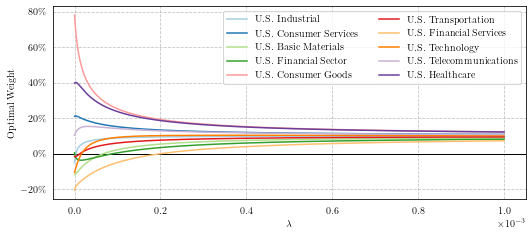

In [84]:
import cvxpy as cp
sample = etf_er.iloc[:, :10].copy()
sample.columns = [etf_meta.loc[x, 'aesthetic'] for x in sample.columns]
Sigma = sample.dropna().cov().values
n = sample.shape[1]
# lb = -1
# ub = 1
A = np.ones((1, n))
b = np.array(1)
# G = np.concatenate([-np.eye(n), np.eye(n)])
# h = np.array([-lb] * n + [ub] * n)

res = pd.DataFrame(index=np.linspace(0, .001, 500), columns=sample.columns)
for lambda_ in res.index:
    x = cp.Variable(n)
    prob = cp.Problem(
        objective=cp.Minimize((1/2) * cp.quad_form(x, Sigma) + lambda_ * cp.quad_form(x, np.eye(n))),
        constraints=[A @ x == b]
    )
    prob.solve()
    res.loc[lambda_] = x.value

color_map = list(cm.get_cmap('Paired')(range(n)))
fig, ax = plt.subplots(figsize=(width, .75 * height))

for i, c in enumerate(res):
    line = res[c]
    ax.plot(line, color=color_map[i], zorder=100)

ax.set_ylabel('Optimal Weight')
ax.set_xlabel('$\lambda$')
ax.legend(res.columns, ncol=2)

plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.axhline(0, c='k', lw=1, zorder=10)
ax.grid(ls='--', alpha=.75, zorder=-99)
plt.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.savefig('l2reg.pdf', dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()

___
# Results

In [2]:
summary_mdl = pd.read_pickle(fr'{wd}\data\ch1\summary_mdl_2.pkl')
# summary_mdl = pd.read_pickle(fr'{wd}\data\ch1\summary_mdl_3_0E0.pkl')
summary_ew = pd.read_pickle(fr'{wd}\data\ch1\summary_ew_2.pkl')
summary_erc = pd.read_pickle(fr'{wd}\data\ch1\summary_erc_2.pkl')

# summary_mdl['Concentration'] = summary_mdl['Concentration'].apply(lambda x: 2 ** x)
# summary_mdl['Concentration'] = summary_mdl['Concentration'].apply(lambda x: np.log10(x))

### Sharpe ratio density plots

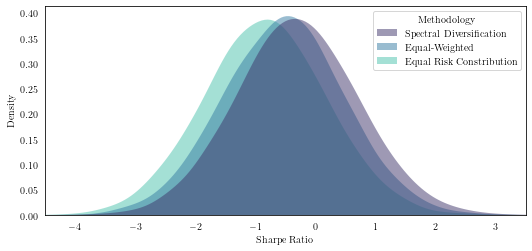

In [3]:
sim_sr = pd.concat([
    summary_mdl['Sharpe'], 
    summary_ew['Sharpe'], 
    summary_erc['Sharpe']
], axis=1)
sim_sr.columns = [
    'Spectral Diversification', 
    'Equal-Weighted', 
    'Equal Risk Constribution'
]
sim_sr = sim_sr.melt()
sim_sr.columns = ['Methodology', 'Sharpe Ratio']

# Plot
fig, ax = plt.subplots(figsize=(width, height * .8))
sns.kdeplot(
    data=sim_sr, 
    x='Sharpe Ratio', 
    hue='Methodology',
    fill=True, 
    common_norm=False, 
    palette="mako",
    alpha=.5, 
    linewidth=0,
    ax=ax,
    zorder=50,
    bw_adjust=1.5
)
ax.tick_params(left=False, bottom=False)
# ax.grid(ls='--', zorder=-99, alpha=.75)
ax.set_xlim(-4.5, 3.5)
plt.tight_layout()
# plt.savefig(rf'{wd}\img\sr_density.pdf', dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()

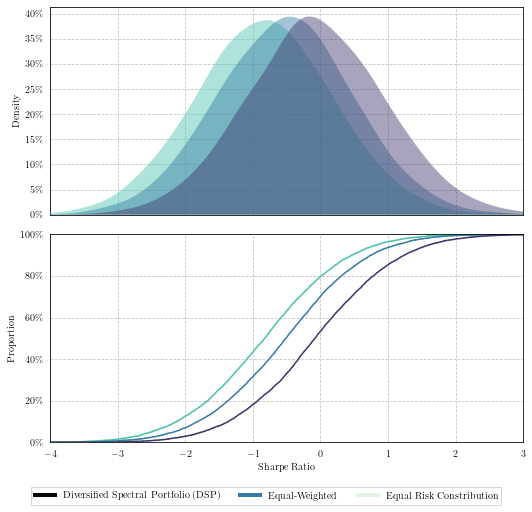

In [30]:
sim_sr = pd.concat([
    summary_mdl['Sharpe'], 
    summary_ew['Sharpe'],
    summary_erc['Sharpe']
], axis=1)

labels = [
    'Diversified Spectral Portfolio (DSP)', 
    'Equal-Weighted',
    'Equal Risk Constribution'
]

sim_sr.columns = labels
sim_sr_long = sim_sr.melt()
sim_sr_long.columns = ['Methodology', 'Sharpe Ratio']

# Plot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(width, height * 1.5), sharex=True)
sns.kdeplot(
    data=sim_sr_long, 
    x='Sharpe Ratio', 
    hue='Methodology',
    fill=True, 
    common_norm=False, 
    palette="mako",
    alpha=.45, 
    linewidth=0,
    ax=axs[0],
    zorder=50,
    legend=False,
    bw_adjust=1.5
)

sns.ecdfplot(
    data=sim_sr_long, 
    x='Sharpe Ratio', 
    hue='Methodology', 
    palette="mako",
    legend=False,
    ax=axs[1]
)

for i in range(2):
    axs[i].tick_params(left=False, bottom=False)
    axs[i].grid(ls='--', zorder=-99, alpha=.75)
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    axs[i].set_xlim(-4, 3)

cmap = sns.color_palette("mako", as_cmap=True)
custom_lines = [
    Line2D([0], [0], color=cmap(0.), lw=4),
    Line2D([0], [0], color=cmap(.5), lw=4),
    Line2D([0], [0], color=cmap(1.), lw=4)
]
fig.legend(custom_lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.0), fancybox=False, shadow=False, ncol=3)
    
# axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, shadow=False, ncol=3)
plt.tight_layout()
plt.savefig(rf'{wd}\img\sr_density_twopanels.pdf', dpi=dpi, transparent=True, bbox_inches='tight')
plt.show()

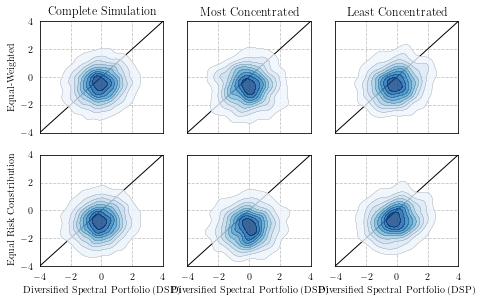

In [32]:
conc_1st = summary_mdl['Concentration'] <= summary_mdl['Concentration'].quantile(.1)
conc_10th = summary_mdl['Concentration'] >= summary_mdl['Concentration'].quantile(.9)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width, height), sharex=True, sharey=True)

quad = {
    (0, 0): ('Equal-Weighted', sim_sr),
    (1, 0): ('Equal Risk Constribution', sim_sr),
    (0, 1): ('Equal-Weighted', sim_sr.loc[conc_1st]),
    (1, 1): ('Equal Risk Constribution', sim_sr.loc[conc_1st]),
    (0, 2): ('Equal-Weighted', sim_sr.loc[conc_10th]),
    (1, 2): ('Equal Risk Constribution', sim_sr.loc[conc_10th])
}

for q in quad:
    sns.kdeplot(x='Diversified Spectral Portfolio (DSP)', y=quad[q][0], ax=axs[q], data=quad[q][1], fill=True, zorder=50, cmap=sns.color_palette("Blues", as_cmap=True), alpha=.8)
    sns.kdeplot(x='Diversified Spectral Portfolio (DSP)', y=quad[q][0], ax=axs[q], data=quad[q][1], fill=False, zorder=55, color='black', linewidths=.25, alpha=.5)
    axs[q].tick_params(left=False, bottom=False)
    axs[q].grid(ls='--', zorder=-99, alpha=.75)
    axs[q].plot([-4, 4], [-4, 4], color='black', lw=1)
    # axs[q].set_facecolor("floralwhite")

axs[0, 0].set_title('Complete Simulation')
axs[0, 1].set_title('Most Concentrated')
axs[0, 2].set_title('Least Concentrated')
    
axs[0, 0].set_xlim(-4, 4)
axs[0, 0].set_ylim(-4, 4)

# plt.tight_layout()
plt.savefig('sr_joint_density_perc_wide.pdf', dpi=dpi, transparent=False, bbox_inches='tight')
plt.show()

In [9]:
idx = pd.MultiIndex.from_tuples([('Spectral Diversification', 'H0: F(X) = G(X)'), ('Spectral Diversification', 'H0: F(X) >= G(X)')])
idx = ['Diversified Spectral Diversification (DSP)']
cols = ['Equal-Weighted', 'Equal Risk Contribution']
ks_table_p = pd.DataFrame(index=idx, columns=cols)
ks_table_t = pd.DataFrame(index=idx, columns=cols)

samples_bm = {
    0: summary_ew['Sharpe'],
    1: summary_erc['Sharpe']
}

sample1 = summary_mdl['Sharpe']
for col in samples_bm.keys():
    sample2 = samples_bm[col]
    # ks_table_t.iloc[0, col], ks_table_p.iloc[0, col] = stats.ks_2samp(sample1, sample2, alternative='two-sided')
    ks_table_t.iloc[0, col], ks_table_p.iloc[0, col] = stats.ks_2samp(sample1, sample2, alternative='less')

print(ks_table_t.values)
print(ks_table_p.values)

[[0.0849 0.2112]]
[[4.569468666783073e-32 6.675186404119279e-196]]


In [10]:
stats.ks_2samp(sample1, sample2, alternative='less')

KstestResult(statistic=0.2112, pvalue=6.675186404119279e-196)